In [38]:
import silence_tensorflow.auto
from embiggen import GraphVisualization
from embiggen.node_prediction import NoLaN
from embiggen.utils import compute_node_embedding
from plot_keras_history import plot_history
from tqdm.auto import tqdm

## Loading the graph

In [34]:
from ensmallen_graph.datasets.linqs import Cora, CiteSeer, PubMedDiabetes
from ensmallen_graph.datasets.linqs.parse_linqs import get_words_data

complete_graph = Cora()
graph = complete_graph.remove(
    deny_node_types_set=set(["Word", "Unknown"]),
).remove(
    singletons=True, selfloops=True
)

graph.enable(
    vector_destinations=True,
    vector_outbounds=True
)

In [35]:
graph

The undirected graph Cora has 2708 nodes with 7 different node types:  the 5 most common are Neural_Networks (nodes number 818), Probabilistic_Methods (nodes number 426), Genetic_Algorithms (nodes number 418), Theory (nodes number 351) and Case_Based (nodes number 298). and 5278 weighted edges with a single edge type: Paper2Paper, of which none are self-loops. The graph is sparse as it has a density of 0.00144 and has 78 connected components, where the component with most nodes has 2485 nodes and the component with the least nodes has 2 nodes. The graph median node degree is 3, the mean node degree is 3.90, and the node degree mode is 2. The top 5 most central nodes are 35 (degree 168), 6213 (degree 78), 1365 (degree 74), 3229 (degree 65) and 910 (degree 44). The hash of the graph is a7269ea66ba0be06.

In [36]:
words_features = get_words_data(complete_graph)
words_features

Extracting words features:   0%|          | 0/4141 [00:00<?, ?it/s]

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_1423,word_1424,word_1425,word_1426,word_1427,word_1428,word_1429,word_1430,word_1431,word_1432
1153728,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
950052,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1152858,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1114502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
362926,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
628667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Computing the node embedding

In [26]:
configuration = {
    "Cora": dict(
        negative_samples=200,
        explore_weight=10.0,
        return_weight=0.1,
    ),
    "CiteSeer": dict(
        batch_size=128,
        iterations=32
    ),
    "PubMedDiabetes": dict(
        batch_size=128,
        iterations=32
    )
}[graph.get_name()]

In [69]:
import inspect
from embiggen import GraphSkipGram

"negative_samples" in 

True

In [27]:
node_embedding, _ = compute_node_embedding(
    graph,
    node_embedding_method_name="SkipGram",
    optimizer="nadam",
    **configuration
)

words_features = words_features.loc[node_embedding.index]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [37]:
configuration = {
    "Cora": dict(),
    "CiteSeer": dict(
        node_embedding_dropout_rate=0.4,
        node_features_dropout_rate=0.7,
        l2_kernel_regularization=0.02,
    ),
    "PubMedDiabetes": dict(
        node_embedding_dropout_rate=0.2,
        node_features_dropout_rate=0.2,
        l1_kernel_regularization=1e-4,
        hidden_dense_layers=256
    )
}[graph.get_name()]

In [46]:
from glob import glob
import pandas as pd

train, test = graph.node_label_holdout(0.8)
subtrain, valid = train.node_label_holdout(0.8)
all_performance = []
histories = []
for path in tqdm(glob("node_embeddings/SkipGram/Cora/*_embedding.csv.xz")):
    node_embedding = pd.read_csv(path, index_col=0)
    node_embedding.index = node_embedding.index.astype("str")
    words_features = words_features.loc[node_embedding.index]
    nolan = NoLaN(
        graph,
        node_embedding=node_embedding,
        node_features=words_features,
        **configuration
    )
    history = nolan.fit(
        subtrain,
        validation_graph=valid,
        verbose=False
    )
    performance = nolan.evaluate(subtrain, validation_graph=valid)
    performance["embedding_path"] = path
    histories.append(history)
    all_performance.append(performance)

  0%|          | 0/102 [00:00<?, ?it/s]

In [56]:
all_perfs_df = pd.concat(all_performance)
all_perfs_df = all_perfs_df[all_perfs_df.run_type=="validation"]
best = all_perfs_df.iloc[all_perfs_df.accuracy.argmax()]

In [58]:
best

loss                                                       0.939992
accuracy                                                   0.900922
recall                                                     0.762673
precision                                                  0.948424
AUROC                                                      0.983066
AUPRC                                                      0.942366
run_type                                                 validation
embedding_path    node_embeddings/SkipGram/Cora/48b52fa44a5c2d30...
Name: 1, dtype: object

In [59]:
node_embedding = pd.read_csv(best.embedding_path, index_col=0)
node_embedding.index = node_embedding.index.astype("str")
words_features = words_features.loc[node_embedding.index]
nolan = NoLaN(
    graph,
    node_embedding=node_embedding,
    node_features=words_features,
    **configuration
)
history = nolan.fit(
    train,
    validation_graph=test
)
nolan.evaluate(train, validation_graph=test)

,loss,accuracy,recall,precision,AUROC,AUPRC,run_type
0,0.762619,0.947295,0.883495,0.984037,0.998233,0.99012,training
1,0.958128,0.878899,0.783486,0.930283,0.979259,0.92840,validation


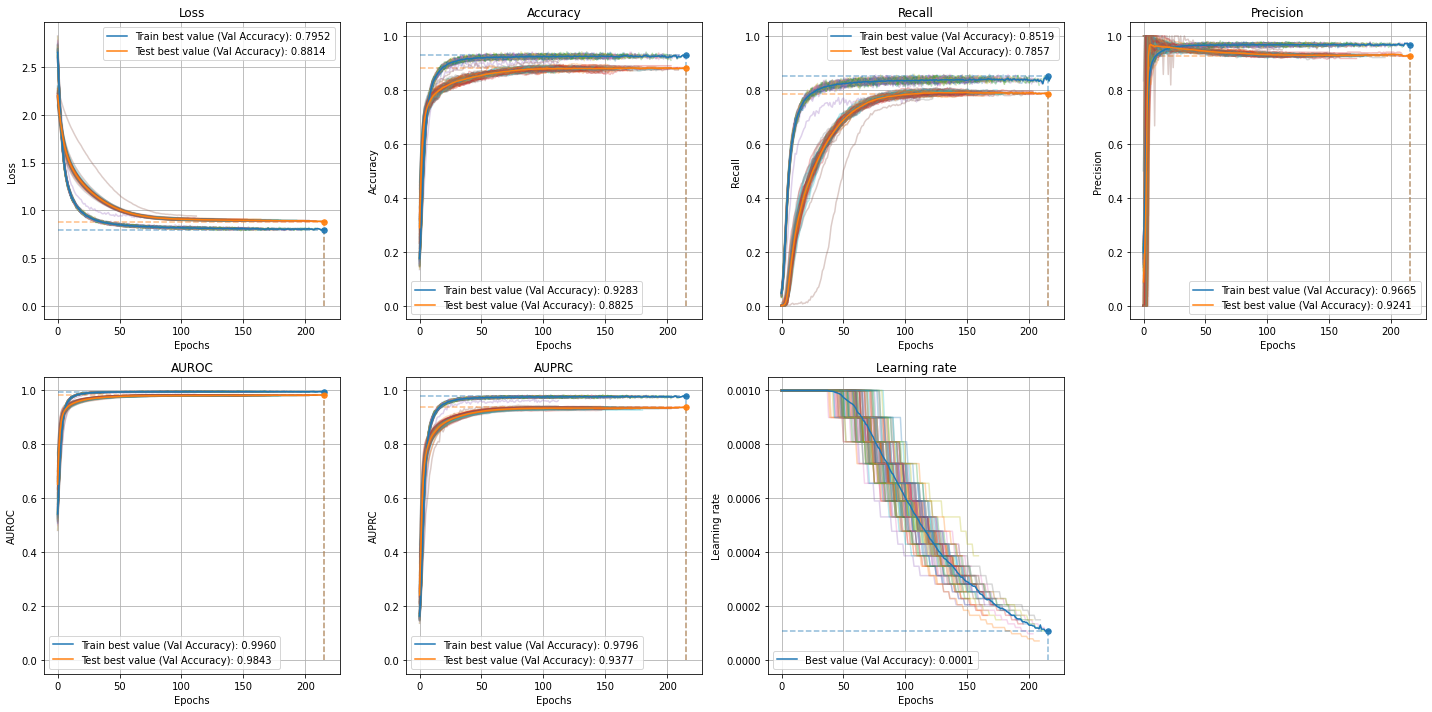

In [47]:
plot_history(histories, monitor="val_accuracy")

In [ ]:
plot_history(histories, monitor="val_accuracy")

In [33]:
nolan.evaluate(train, validation_graph=test)

,loss,accuracy,recall,precision,AUROC,AUPRC,run_type
0,0.769670,0.950069,0.881646,0.981472,0.998113,0.989550,training
1,0.966784,0.878899,0.776147,0.921569,0.979496,0.927564,validation


## Visualizing the node embedding

In [22]:
predictions = nolan.predict(np.arange(graph.get_nodes_number())).argmax(axis=1)

In [13]:
import pandas as pd

visualization = GraphVisualization(
    graph,
    node_embedding_method="SkipGram embedding with NoLaN predictions"
)
visualization.fit_transform_nodes(pd.concat(
    (node_embedding, words_features),
    axis=1
))

KeyboardInterrupt: 

In [ ]:
visualization.plot_node_types(
    node_type_predictions=predictions,
    train_indices=X_train,
    test_indices=X_test
)

In [ ]:
visualization.plot_connected_components(train_indices=X_train, test_indices=X_test)

In [ ]:
visualization.plot_node_degrees(train_indices=X_train, test_indices=X_test)